In [72]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandasql import sqldf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import missingno as msno
import sqlite3 as sql

from scipy import stats 
from scipy.stats import f_oneway, kruskal
from scipy.stats import shapiro, kstest, yeojohnson, boxcox

from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime as dt

## Enoncé

Vous êtes consultant pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne. 

## Mission

Votre rôle est d’accompagner Olist dans leur projet de monter une équipe Data et leur premier cas d’usage Data Science autour de la segmentation client.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication. 

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnell

 

Vous devrez fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

In [73]:
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
order_dataset = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
translation = pd.read_csv('product_category_name_translation.csv')

## I- Visualisation des données 

### 1.1) Customers

In [74]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [75]:
# Combien de lignes et de colonnes ?
print('Shape : ' + str(customers.shape))

Shape : (99441, 5)


In [76]:
# Affichage du nom des colonnes, du type des colonnes et du nombre de variable par type
print(customers.info(verbose=True))
print(customers.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
object    4
int64     1
Name: count, dtype: int64


In [77]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
print(customers.isna().mean().sort_values())

customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64


In [78]:
#Combien y a-t-il de valeurs différentes par colonne ?
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

Ce jeu de données contient 99 441 lignes et 5 variables sans valeur manquante. Il apporte des informations sur :
- L'identifiant attribué à un client pour chaque commande
- L'identifiant unique attribué à chaque client
- Les 5 premiers chiffres du code postal du client, sa ville et son payse.

### 1.2) Geolocation

In [79]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [80]:
# Combien de lignes et de colonnes ?
print('Shape : ' + str(geolocation.shape))

Shape : (1000163, 5)


In [81]:
# Affichage du nom des colonnes, du type des colonnes et du nombre de variable par type
print(geolocation.info(verbose=True))
print(geolocation.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
None
float64    2
object     2
int64      1
Name: count, dtype: int64


In [82]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
print(geolocation.isna().mean().sort_values())

geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64


In [83]:
#Combien y a-t-il de valeurs différentes par colonne ?
geolocation.nunique()

geolocation_zip_code_prefix     19015
geolocation_lat                717360
geolocation_lng                717613
geolocation_city                 8011
geolocation_state                  27
dtype: int64

Ce jeu de données contient 1 000 163 lignes et 5 variables sans valeur manquante. Il donne des informations sur les différents codes postaux du Brésil, ainsi que les latitude, longitude et ville associés à ces codes postaux.

### 1.3) Order_items

In [84]:
# Afficher le dataset pour vérifier les données
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [85]:
# Combien de lignes et de colonnes ?
print('Shape : ' + str(order_items.shape))

Shape : (112650, 7)


In [86]:
# Affichage du nom des colonnes, du type des colonnes et du nombre de variable par type
print(order_items.info(verbose=True))
print(order_items.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
None
object     4
float64    2
int64      1
Name: count, dtype: int64


In [87]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
print(order_items.isna().mean().sort_values())

order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64


In [88]:
#Combien y a-t-il de valeurs différentes par colonne ?
order_items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [89]:
# Statistiques descriptives
order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


Ce jeu de données contient 112 650 lignes et 7 variables sans valeur manquante. Il apporte des informations sur :
- L'identifiant de la commande
- Le nombre de produit par commande
- L'identifiant des produits
- L'identifiant du vendeur
- La date limite d'expédition
- Le prix de la commande
- Le prix des frais d'expédition

### 1.4) Order_payments

In [90]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [91]:
# Combien de lignes et de colonnes ?
print('Shape : ' + str(order_payments.shape))

Shape : (103886, 5)


In [92]:
# Affichage du nom des colonnes, du type des colonnes et du nombre de variable par type
print(order_payments.info(verbose=True))
print(order_payments.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
None
object     2
int64      2
float64    1
Name: count, dtype: int64


In [93]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
print(order_payments.isna().mean().sort_values())

order_id                0.0
payment_sequential      0.0
payment_type            0.0
payment_installments    0.0
payment_value           0.0
dtype: float64


In [94]:
#Combien y a-t-il de valeurs différentes par colonne ?
order_payments.nunique()

order_id                99440
payment_sequential         29
payment_type                5
payment_installments       24
payment_value           29077
dtype: int64

In [95]:
# Statistiques descriptives
order_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


Ce jeu de données comporte 103886 lignes et 5 variables sans valeur manquante. Il apporte des informations sur :
- L'identifiant de la commande
- Le nombre de mode de paiment
- Le mode de paiement
- Le nombre de versement
- Le montant du paiement

### 1.5) Order_reviews

In [96]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [97]:
# Combien de lignes et de colonnes ?
print('Shape : ' + str(order_reviews.shape))

Shape : (99224, 7)


In [98]:
# Affichage du nom des colonnes, du type des colonnes et du nombre de variable par type
print(order_reviews.info(verbose=True))
print(order_reviews.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None
object    6
int64     1
Name: count, dtype: int64


review_id                  0.000000
order_id                   0.000000
review_score               0.000000
review_creation_date       0.000000
review_answer_timestamp    0.000000
review_comment_message     0.587025
review_comment_title       0.883415
dtype: float64


<Axes: >

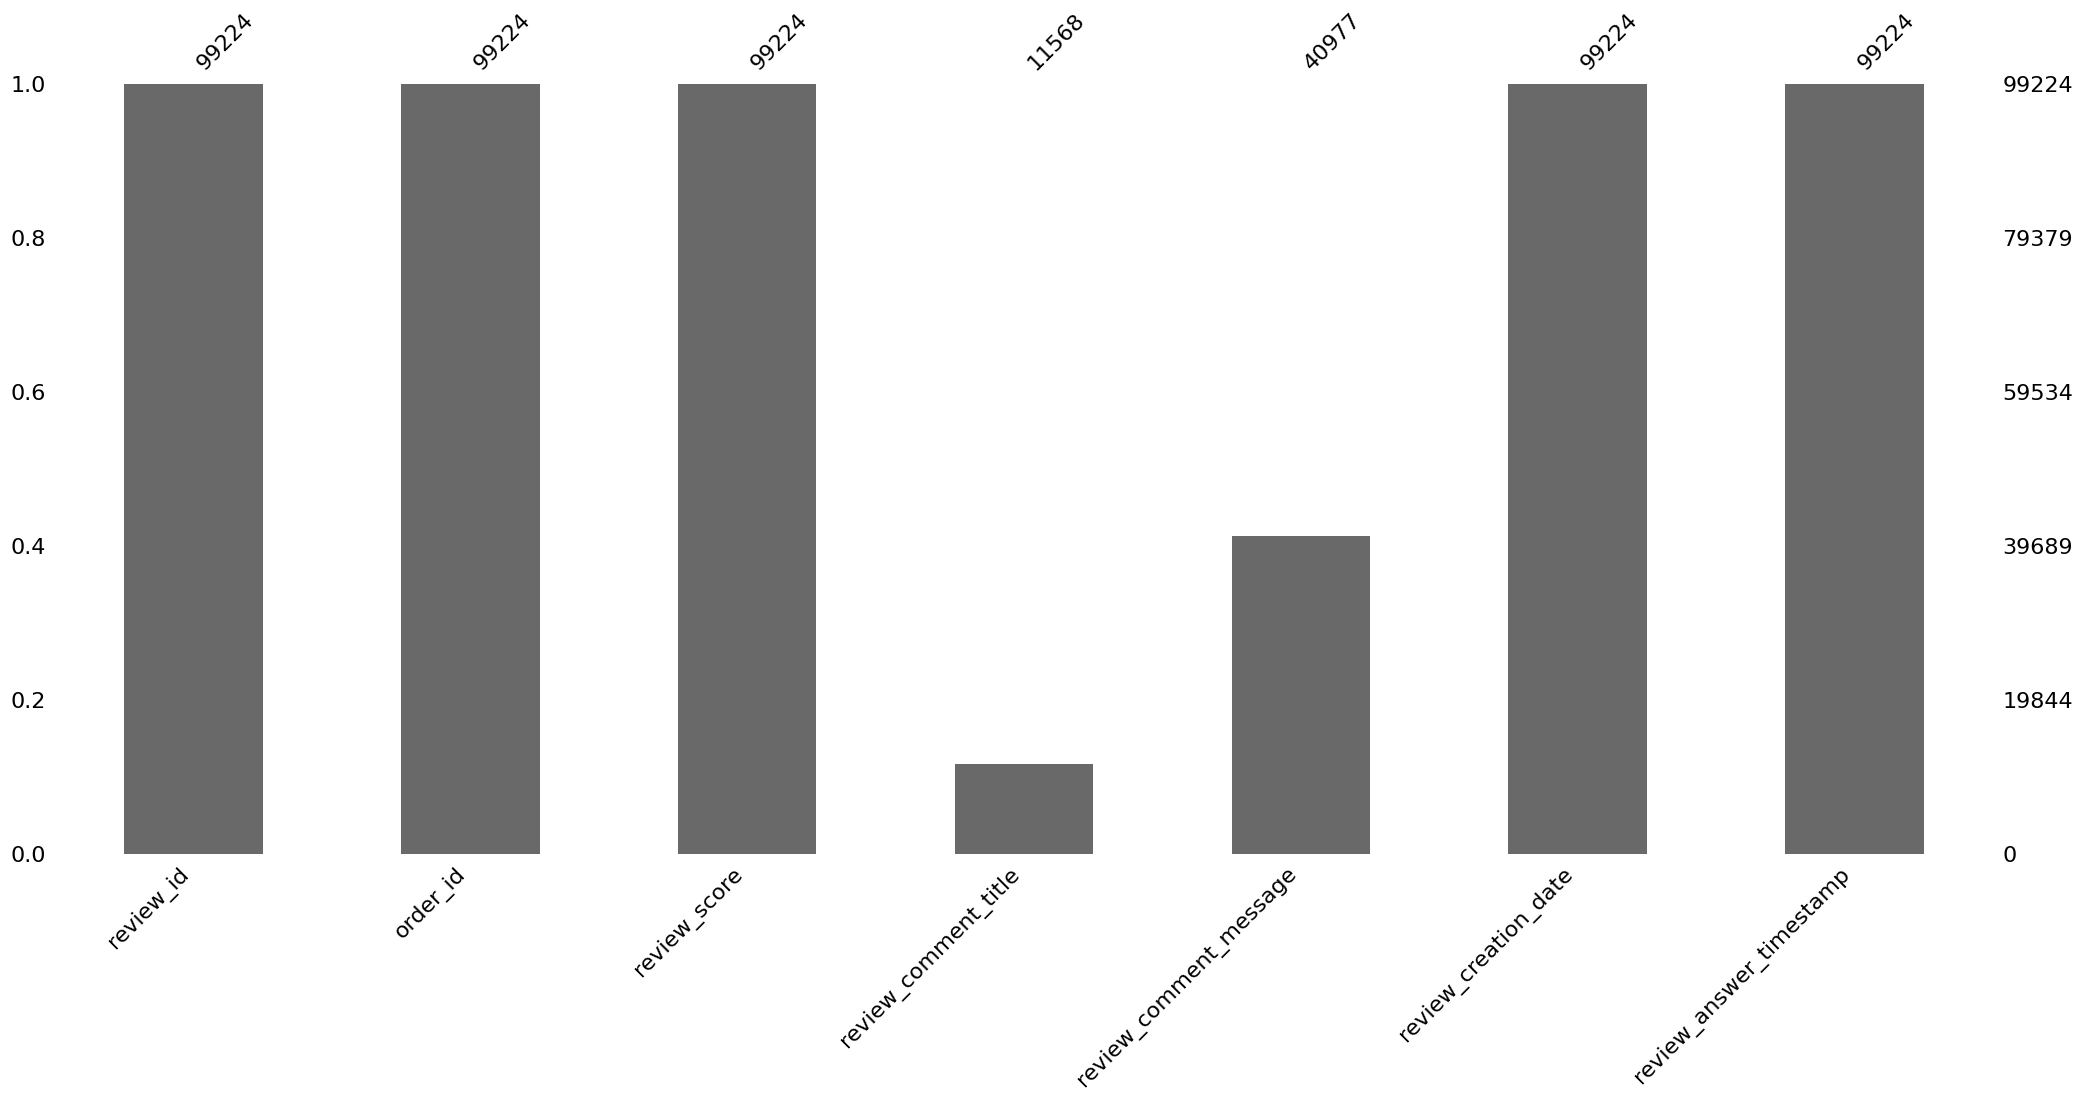

In [99]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
print(order_reviews.isna().mean().sort_values())
msno.bar(order_reviews)

In [100]:
#Combien y a-t-il de valeurs différentes par colonne ?
order_reviews.nunique()

review_id                  98410
order_id                   98673
review_score                   5
review_comment_title        4527
review_comment_message     36159
review_creation_date         636
review_answer_timestamp    98248
dtype: int64

In [101]:
# Statistiques descriptives
order_reviews.describe()

,review_score
count,99224.000000
mean,4.086421
std,1.347579
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


Ce jeu de données contient 99 224 observations et 7 variables avec des valeurs manquantes pour les variables 'review_comment_message' et 'review_comment_title'. Il apporte des informations sur :
- L'identifiant du retour de l'enquête de satisfaction du client
- L'identifiant de la commande
- La note attribuée
- Le titre du commentaire
- Le texte du commentaire
- La date d'envoi de l'enquête de satisfaction
- La date de réponse à l'enquête

### 1.6) Order_dataset 

In [102]:
order_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [103]:
# Combien de lignes et de colonnes ?
print('Shape : ' + str(order_dataset.shape))

Shape : (99441, 8)


In [104]:
# Affichage du nom des colonnes, du type des colonnes et du nombre de variable par type
print(order_dataset.info(verbose=True))
print(order_dataset.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None
object    8
Name: count, dtype: int64


order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_estimated_delivery_date    0.000000
order_approved_at                0.001609
order_delivered_carrier_date     0.017930
order_delivered_customer_date    0.029817
dtype: float64


<Axes: >

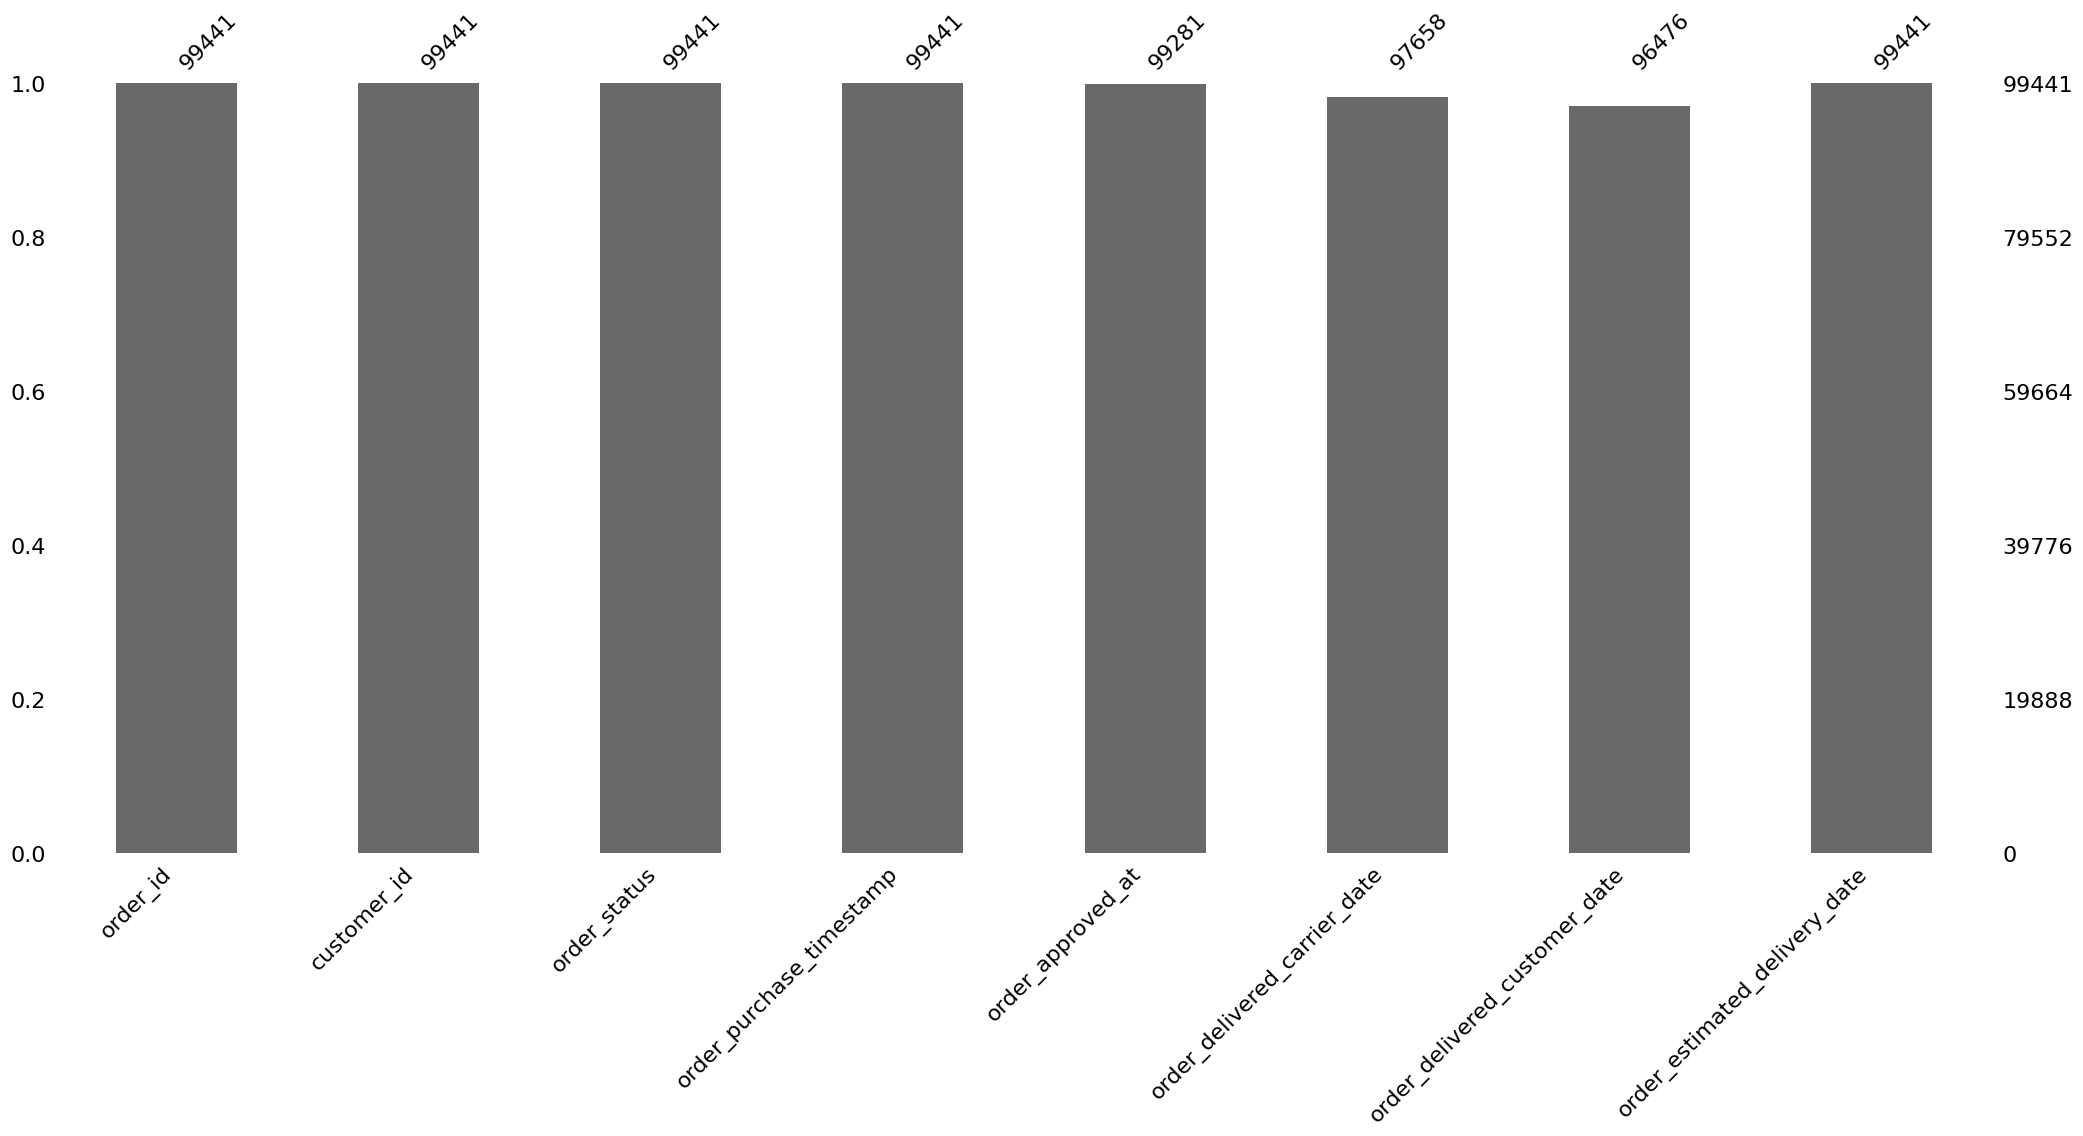

In [105]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
print(order_dataset.isna().mean().sort_values())
msno.bar(order_dataset)

In [106]:
#Combien y a-t-il de valeurs différentes par colonne ?
order_dataset.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [107]:
# Statistiques descriptives
order_dataset.describe()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


Ce jeu de données contient 99441 lignes et  8 variables avec des valeurs manquantes pour les variables 'order_approved_at', 'order_delivered_carrier_date' et 'order_delivered_customer_date'. Ce jeu de données apportent des informations sur :

- L'identifiant de la commande
- L'identifiant du client pour cette commande
- Le statut de la commande
- La date de la commande
- La date d'approbation de la commande
- La date de prise en charge de la commande par le transporteur
- La date de livraison réelle
- La date de livraison prévue

### 1.7) Products

In [108]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [109]:
# Combien de lignes et de colonnes ?
print('Shape : ' + str(products.shape))

Shape : (32951, 9)


In [110]:
# Affichage du nom des colonnes, du type des colonnes et du nombre de variable par type
print(products.info(verbose=True))
print(products.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
None
float64    7
object     2
Name: count, dtype: int64


product_id                    0.000000
product_weight_g              0.000061
product_length_cm             0.000061
product_height_cm             0.000061
product_width_cm              0.000061
product_category_name         0.018512
product_name_lenght           0.018512
product_description_lenght    0.018512
product_photos_qty            0.018512
dtype: float64


<Axes: >

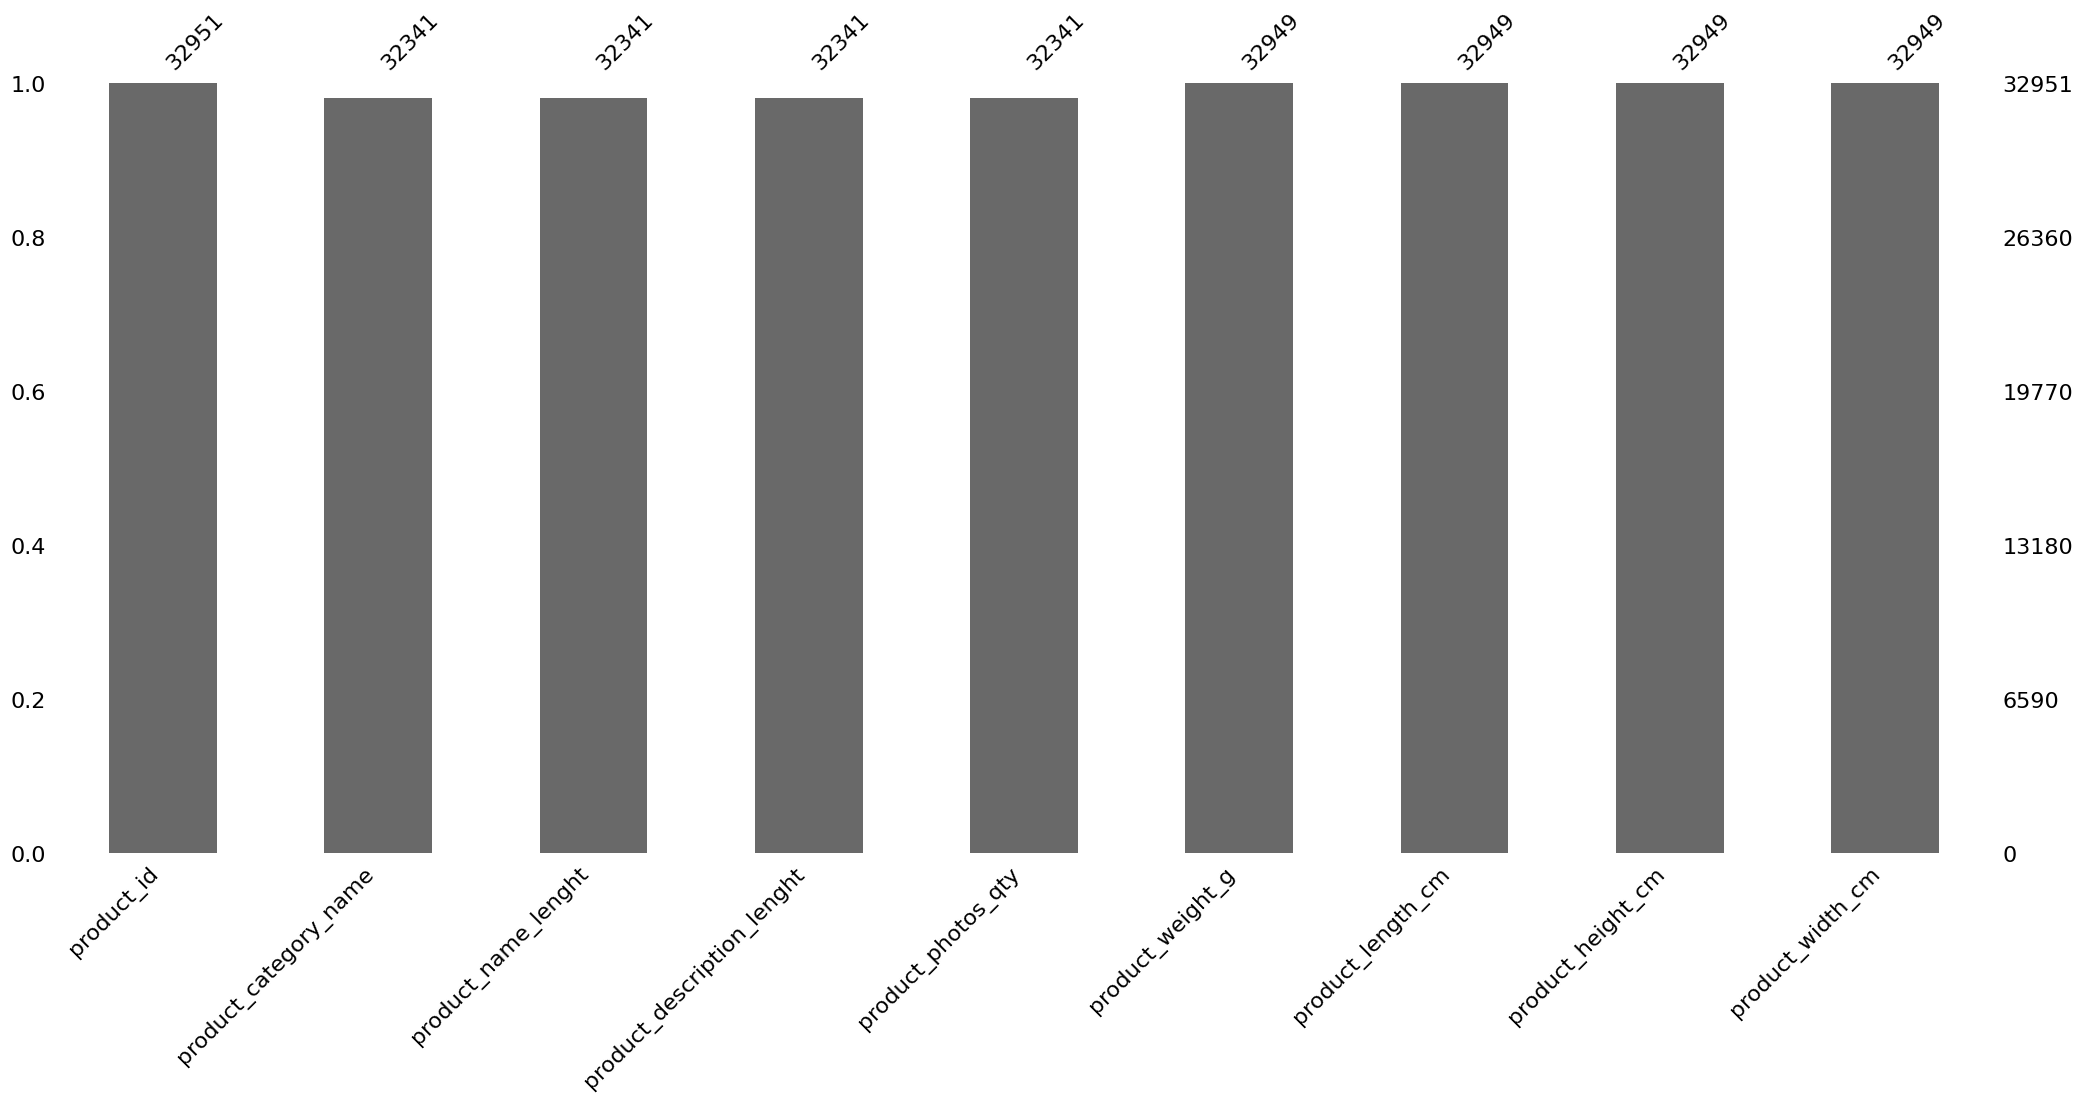

In [111]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
print(products.isna().mean().sort_values())
msno.bar(products)

In [112]:
#Combien y a-t-il de valeurs différentes par colonne ?
products.nunique()

product_id                    32951
product_category_name            73
product_name_lenght              66
product_description_lenght     2960
product_photos_qty               19
product_weight_g               2204
product_length_cm                99
product_height_cm               102
product_width_cm                 95
dtype: int64

In [113]:
# Statistiques descriptives
products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


Ce jeu de données comprend 32951 lignes et 9 variables avec plus ou moins de valeurs manquantes pour pratiquement toutes les variables. Ce jeu de données contient des informations sur :

- L'identifiant du produit
- La catégorie du produit
- Le nombre de caractère extraits du nom du produit
- Le nombre de caractère extraits de la description du produit
- Le nombre de photo publiée pour ce produit
- Le poids du produit en gramme
- La longueur du produit en cm
- La hauteur du produit en cm
- La profondeur du produit en cm

### 1.8) Sellers

In [114]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [115]:
# Combien de lignes et de colonnes ?
print('Shape : ' + str(sellers.shape))

Shape : (3095, 4)


In [116]:
# Affichage du nom des colonnes, du type des colonnes et du nombre de variable par type
print(sellers.info(verbose=True))
print(sellers.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
None
object    3
int64     1
Name: count, dtype: int64


In [117]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
print(sellers.isna().mean().sort_values())

seller_id                 0.0
seller_zip_code_prefix    0.0
seller_city               0.0
seller_state              0.0
dtype: float64


In [118]:
#Combien y a-t-il de valeurs différentes par colonne ?
sellers.nunique()

seller_id                 3095
seller_zip_code_prefix    2246
seller_city                611
seller_state                23
dtype: int64

In [119]:
# Statistiques descriptives
sellers.describe()

,seller_zip_code_prefix
count,3095.000000
mean,32291.059451
std,32713.453830
min,1001.000000
25%,7093.500000
50%,14940.000000
75%,64552.500000
max,99730.000000


Ce jeu de données contient 3095 lignes et 4 variables sans valeur manquante. Il apporte des informations sur :
- L'identifiant du vendeur
- Le code postal du vendeur
- La ville du vendeur
- Le pays du vendeur

### 1.9) Translation

In [120]:
translation.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [121]:
# Combien de lignes et de colonnes ?
print('Shape : ' + str(translation.shape))

Shape : (71, 2)


In [122]:
# Affichage du nom des colonnes, du type des colonnes et du nombre de variable par type
print(translation.info(verbose=True))
print(translation.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB
None
object    2
Name: count, dtype: int64


In [123]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
print(translation.isna().mean().sort_values())

product_category_name            0.0
product_category_name_english    0.0
dtype: float64


In [124]:
#Combien y a-t-il de valeurs différentes par colonne ?
translation.nunique()

product_category_name            71
product_category_name_english    71
dtype: int64

In [125]:
# Statistiques descriptives
translation.describe()

,product_category_name,product_category_name_english
count,71,71
unique,71,71
top,beleza_saude,health_beauty
freq,1,1


Ce jeu de données contient 71 lignes et 2 colonnes. Il apporte des informations sur :
- Le nom de la catégorie du produit en portuguais
- La traduction correspondante en anglais

## II- Nettoyage des données

### 2.1) Jointure des datasets

Les tableaux de la base de données sont organisés de la manière suivante : 
![organisation des tableaux](img.png)

Nous allons d'abord faire un merge de tous les datasets en un dataframe, à l'exception de geolocation qui ne sera pas utile pour la suite.

In [126]:
df = pd.DataFrame()
df = order_dataset.merge(customers, on='customer_id') 
df = df.merge(order_items, on='order_id')
df = df.merge(order_payments, on='order_id')
df = df.merge(order_reviews, on='order_id')
df = df.merge(products, on='product_id')
df = df.merge(sellers, on='seller_id')
df = df.merge(translation , on='product_category_name')

In [127]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366,...,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,2290,...,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares


In [128]:
# Combien de lignes et de colonnes ?
print('Shape : ' + str(df.shape))

Shape : (115609, 40)


In [129]:
# Affichage du nom des colonnes, du type des colonnes et du nombre de variable par type
print(df.info(verbose=True))
print(df.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115609 entries, 0 to 115608
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   customer_id                    115609 non-null  object 
 2   order_status                   115609 non-null  object 
 3   order_purchase_timestamp       115609 non-null  object 
 4   order_approved_at              115595 non-null  object 
 5   order_delivered_carrier_date   114414 non-null  object 
 6   order_delivered_customer_date  113209 non-null  object 
 7   order_estimated_delivery_date  115609 non-null  object 
 8   customer_unique_id             115609 non-null  object 
 9   customer_zip_code_prefix       115609 non-null  int64  
 10  customer_city                  115609 non-null  object 
 11  customer_state                 115609 non-null  object 
 12  order_item_id                 

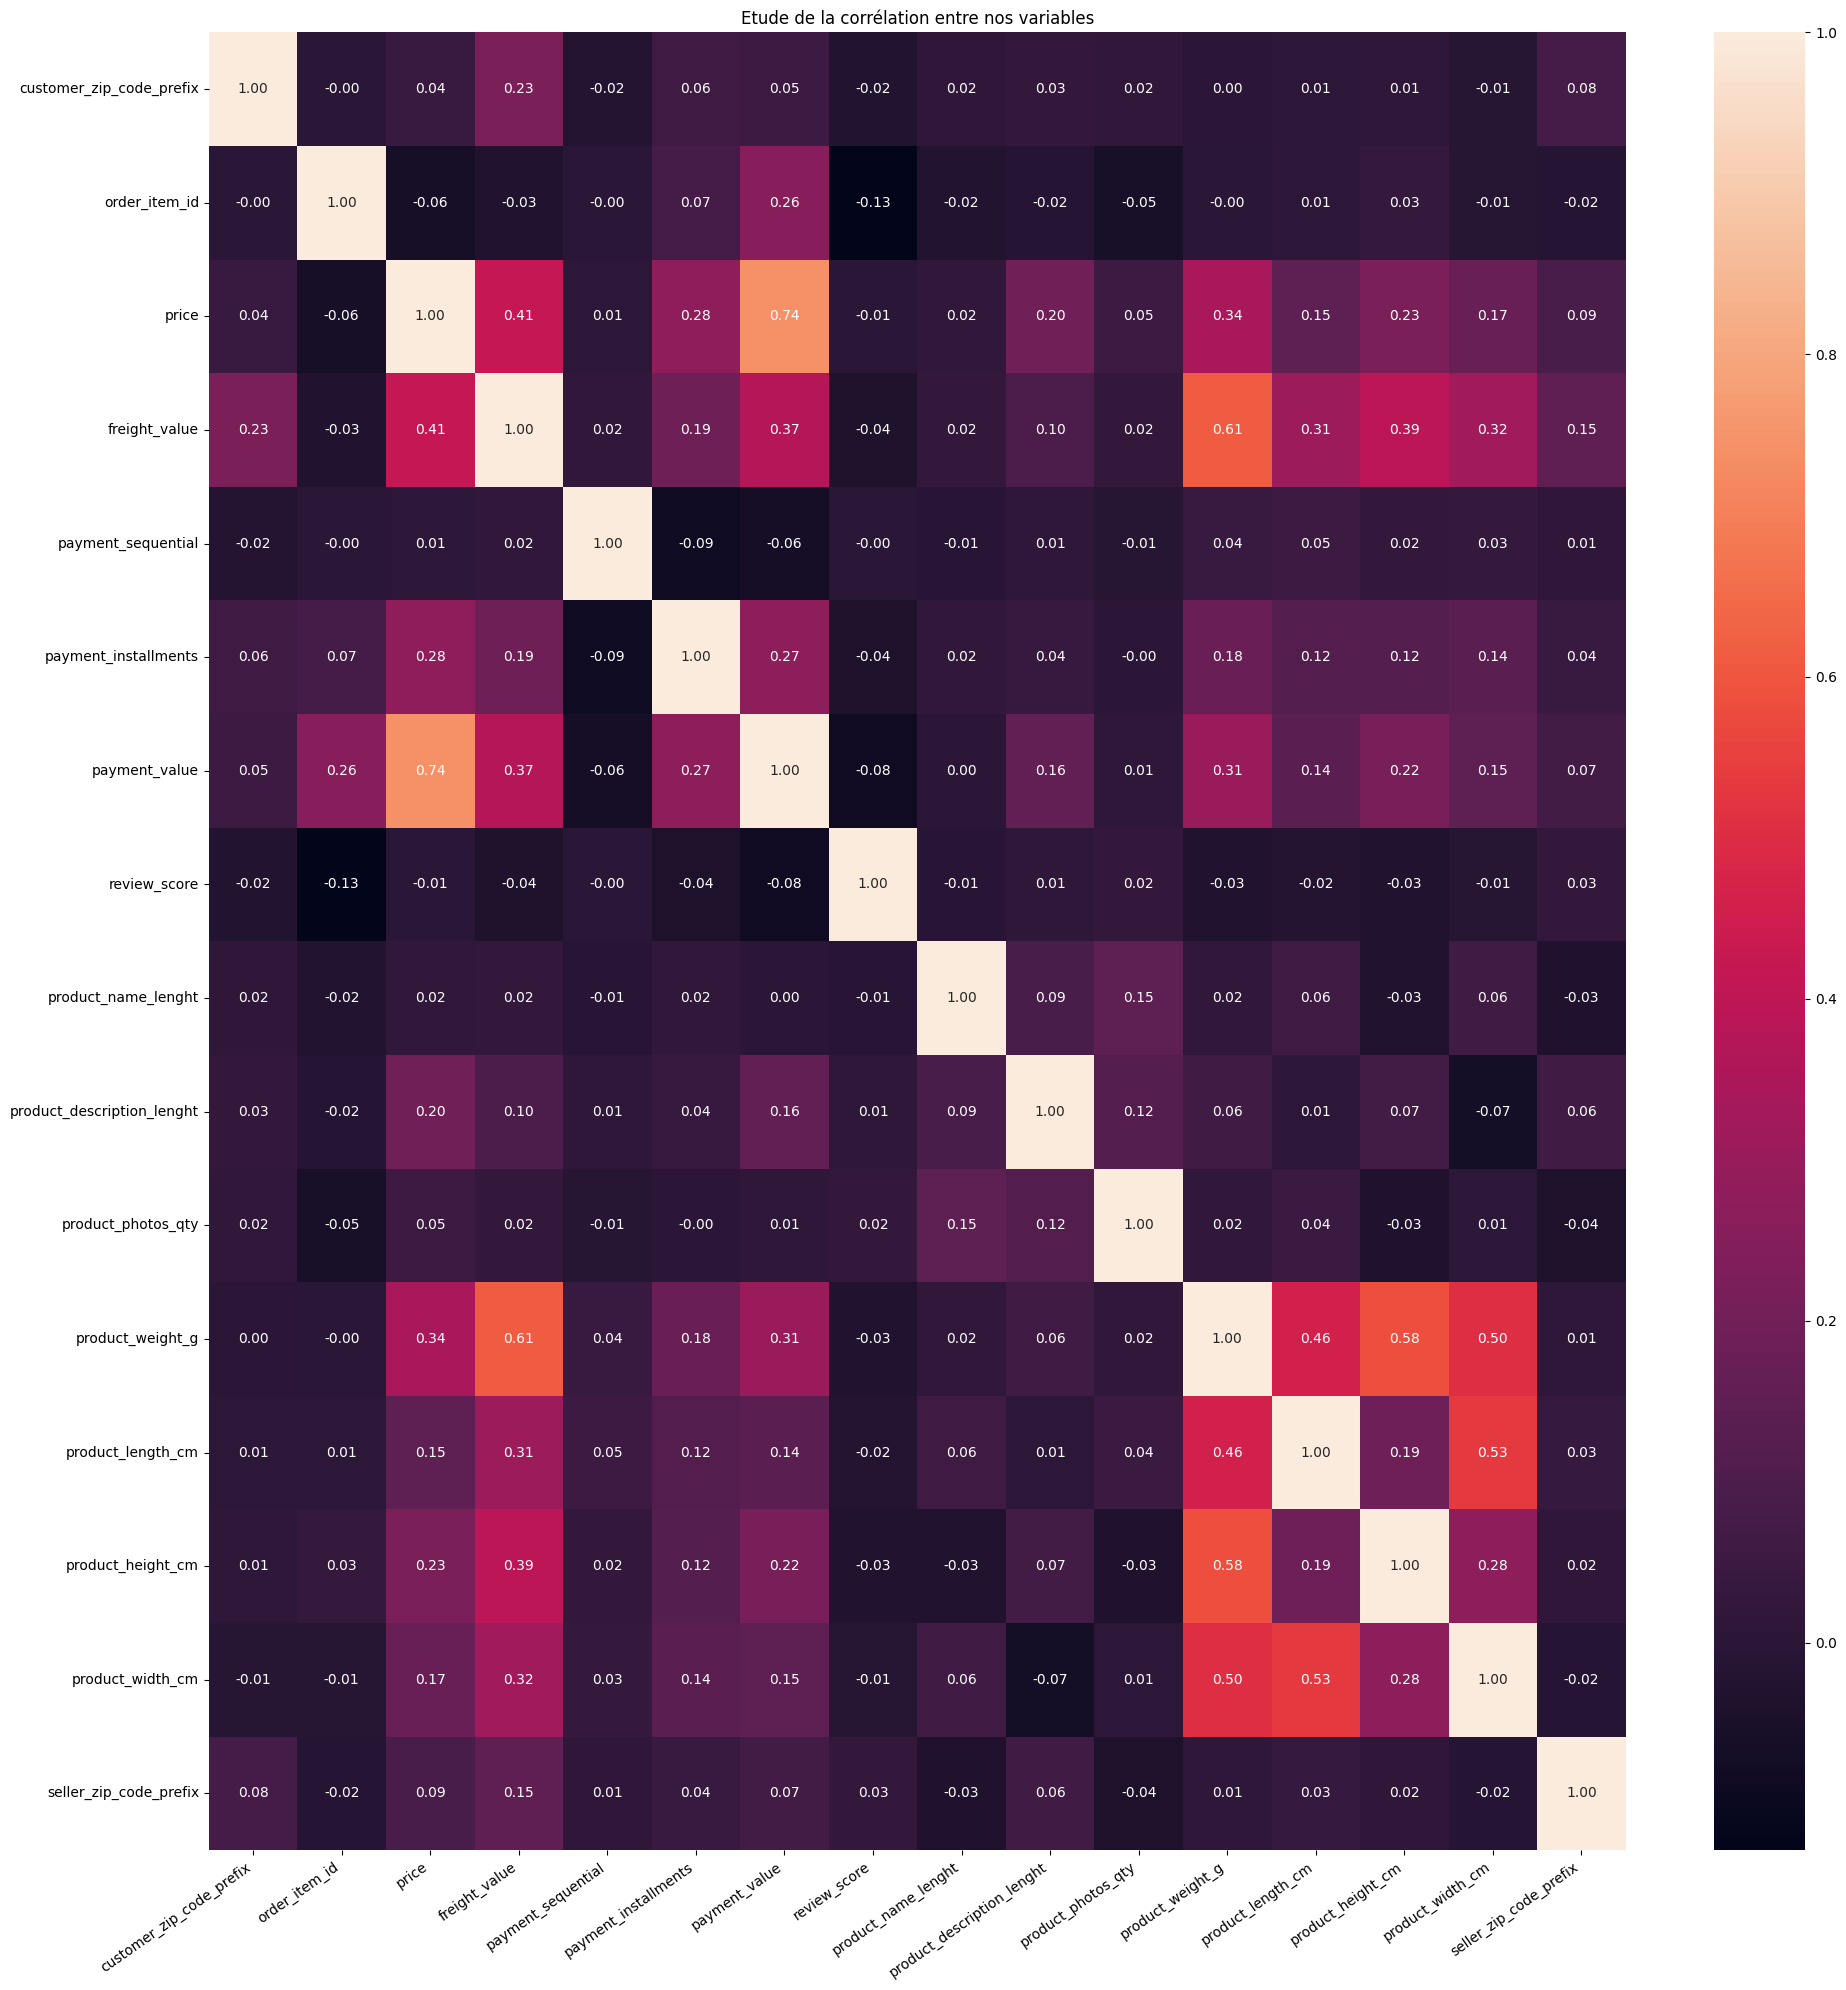

In [130]:
colonnes_quanti = df.select_dtypes(include=['float64',  'int64']).columns

#Matrice de corrélation 
plt.figure(figsize=(20,20))
sns.heatmap(df[colonnes_quanti].corr(), annot=True, fmt='.2f')
plt.title('Etude de la corrélation entre nos variables')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.show()

In [131]:
df.describe()

,customer_zip_code_prefix,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix
count,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115608.000000,115608.000000,115608.000000,115608.000000,115609.000000
mean,35061.537597,1.194535,120.619850,20.056880,1.093747,2.946233,172.387379,4.034409,48.766541,785.808198,2.205373,2113.907697,30.307903,16.638477,23.113167,24515.713958
std,29841.671732,0.685926,182.653476,15.836184,0.729849,2.781087,265.873969,1.385584,10.034187,652.418619,1.717771,3781.754895,16.211108,13.473570,11.755083,27636.640968
min,1003.000000,1.000000,0.850000,0.000000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000
25%,11310.000000,1.000000,39.900000,13.080000,1.000000,1.000000,60.870000,4.000000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000
50%,24241.000000,1.000000,74.900000,16.320000,1.000000,2.000000,108.050000,5.000000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13660.000000
75%,58745.000000,1.000000,134.900000,21.210000,1.000000,4.000000,189.480000,5.000000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,28605.000000
max,99980.000000,21.000000,6735.000000,409.680000,29.000000,24.000000,13664.080000,5.000000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000


### 2.2) Nettoyage

On supprime les lignes duppliquées

In [132]:
#Supprimer les lignes duppliquées
print("Le nombre de doublons dans df est de : ", df[df.duplicated()].shape[0])
df = df.drop_duplicates(keep='first')

Le nombre de doublons dans df est de :  0


On regarde le nombre de valeur unique pour chaque informations géographiques sur l'acheteur et le vendeur. Trop de valeurs uniques ne serait pas pertinent pour la suite

In [133]:
#'customer_zip_code_prefix' et 'customer_city' ont trop de valeurs unique, on garde seulement 'customer_state' pour leur localisation
print(df['customer_zip_code_prefix'].nunique())
print(df['customer_city'].nunique())
print(df['customer_state'].nunique())

14907
4093
27


In [134]:
#'seller_zip_code_prefix' et 'seller_city' ont trop de valeurs unique, on garde seulement 'seller_state' pour leur localisation
print(df['seller_zip_code_prefix'].nunique())
print(df['seller_city'].nunique())
print(df['seller_state'].nunique())

2210
604
23


Suppression des colonnes inutiles pour la suite

In [135]:
#Suppression des colonnes qui ne seront pas utiles pour la suite
df.drop(columns=['customer_zip_code_prefix',
                 'customer_city',
                 'order_approved_at', 
                 'shipping_limit_date',
                 'review_comment_title',
                 'review_comment_message',
                 'review_creation_date',
                 'review_answer_timestamp',
                 'payment_sequential',
                 'product_name_lenght',
                 'product_description_lenght',
                 'seller_zip_code_prefix', 
                 'seller_city',
                 'product_weight_g',
                 'product_length_cm',
                 'product_height_cm',
                 'product_width_cm'
                ], inplace=True)

On change le type des colonnes temporelles

In [136]:
# Convertir les colonnes en type datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

On ne conserve que les commandes délivrées

In [137]:
#Suppression des commandes non délivrées
df = df.loc[df['order_status'] == 'delivered']

#On peut supprimer la colonne 'order_status' qui ne sera plus utile 
df.drop(columns=['order_status'], inplace=True)

On supprime les 3 lignes sans information de paiement

In [138]:
#Suppression des 3 lignes sans information de paiement
nan_payment = df.loc[df['payment_installments'].isna()]
df = df.dropna(subset=['payment_installments'])

On veut un dataframe agrégé et groupé par customer_unique_id

In [139]:
def df_agg(df):
    '''Retourne un dataframe agrégé et groupé en fonction de l'identifiant client unique.
    '''
   
    data_agg = df.groupby('customer_unique_id').agg(
        order_purchase_timestamp=('order_purchase_timestamp', 'max'),
        customer_state=('customer_state', lambda x: x.mode()[0]),
        order_id=('order_id', 'nunique'),
        nb_total_item=('product_id', 'count'),
        price=('price', 'sum'),
        freight_value=('freight_value', 'sum'),
        payment_type=('payment_type', lambda x: x.mode()[0]),
        mean_payment_installments=('payment_installments', 'mean'),
        total_payment_value=('payment_value', 'sum'),
        mean_payment_value=('payment_value', 'mean'),
        mean_review_score=('review_score', 'mean'),
        seller_state=('seller_state', lambda x: x.mode()[0]),
        product_category_name=('product_category_name_english', lambda x: x.mode()[0])
    )

    return data_agg

In [140]:
df = df_agg(df)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91481 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   order_purchase_timestamp   91481 non-null  datetime64[ns]
 1   customer_state             91481 non-null  object        
 2   order_id                   91481 non-null  int64         
 3   nb_total_item              91481 non-null  int64         
 4   price                      91481 non-null  float64       
 5   freight_value              91481 non-null  float64       
 6   payment_type               91481 non-null  object        
 7   mean_payment_installments  91481 non-null  float64       
 8   total_payment_value        91481 non-null  float64       
 9   mean_payment_value         91481 non-null  float64       
 10  mean_review_score          91481 non-null  float64       
 11  seller_state  

In [142]:
df.describe()

,order_purchase_timestamp,order_id,nb_total_item,price,freight_value,mean_payment_installments,total_payment_value,mean_payment_value,mean_review_score
count,91481,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000
mean,2018-01-04 23:46:55.043495424,1.032870,1.237525,148.338325,24.753683,2.903113,212.326244,157.720299,4.154788
min,2016-10-03 16:56:50,1.000000,1.000000,0.850000,0.000000,0.000000,9.590000,1.856818,1.000000
25%,2017-09-18 16:17:16,1.000000,1.000000,48.900000,14.100000,1.000000,63.860000,60.750000,4.000000
50%,2018-01-24 00:23:02,1.000000,1.000000,89.900000,17.730000,2.000000,112.850000,103.470000,5.000000
75%,2018-05-08 12:28:59,1.000000,1.000000,159.900000,26.630000,4.000000,202.760000,174.990000,5.000000
max,2018-08-29 15:00:37,14.000000,75.000000,13440.000000,1794.960000,24.000000,109312.640000,13664.080000,5.000000
std,NaN,0.206215,0.844319,243.748770,27.071499,2.679754,631.282232,215.706278,1.279158


In [143]:
df.to_csv('df_customers.csv')

## III- Analyse exploratoire 

In [144]:
df.head()

,order_purchase_timestamp,customer_state,order_id,nb_total_item,price,freight_value,payment_type,mean_payment_installments,total_payment_value,mean_payment_value,mean_review_score,seller_state,product_category_name
customer_unique_id,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,SP,1,1,129.90,12.00,credit_card,8.0,141.90,141.90,5.0,SP,bed_bath_table
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,SP,1,1,18.90,8.29,credit_card,1.0,27.19,27.19,4.0,SP,health_beauty
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,SC,1,1,69.00,17.22,credit_card,8.0,86.22,86.22,3.0,SP,stationery
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,PA,1,1,25.99,17.63,credit_card,4.0,43.62,43.62,4.0,SP,telephony
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,SP,1,1,180.00,16.89,credit_card,6.0,196.89,196.89,5.0,SP,telephony


In [145]:
# Combien de lignes et de colonnes ?
print('Shape : ' + str(df.shape))

Shape : (91481, 13)


In [146]:
# Affichage du nom des colonnes, du type des colonnes et du nombre de variable par type
print(df.info(verbose=True))
print(df.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 91481 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   order_purchase_timestamp   91481 non-null  datetime64[ns]
 1   customer_state             91481 non-null  object        
 2   order_id                   91481 non-null  int64         
 3   nb_total_item              91481 non-null  int64         
 4   price                      91481 non-null  float64       
 5   freight_value              91481 non-null  float64       
 6   payment_type               91481 non-null  object        
 7   mean_payment_installments  91481 non-null  float64       
 8   total_payment_value        91481 non-null  float64       
 9   mean_payment_value         91481 non-null  float64       
 10  mean_review_score          91481 non-null  float64       
 11  seller_state  

order_purchase_timestamp     0
customer_state               0
order_id                     0
nb_total_item                0
price                        0
freight_value                0
payment_type                 0
mean_payment_installments    0
total_payment_value          0
mean_payment_value           0
mean_review_score            0
seller_state                 0
product_category_name        0
dtype: int64
Axes(0.125,0.11;0.698618x0.77)


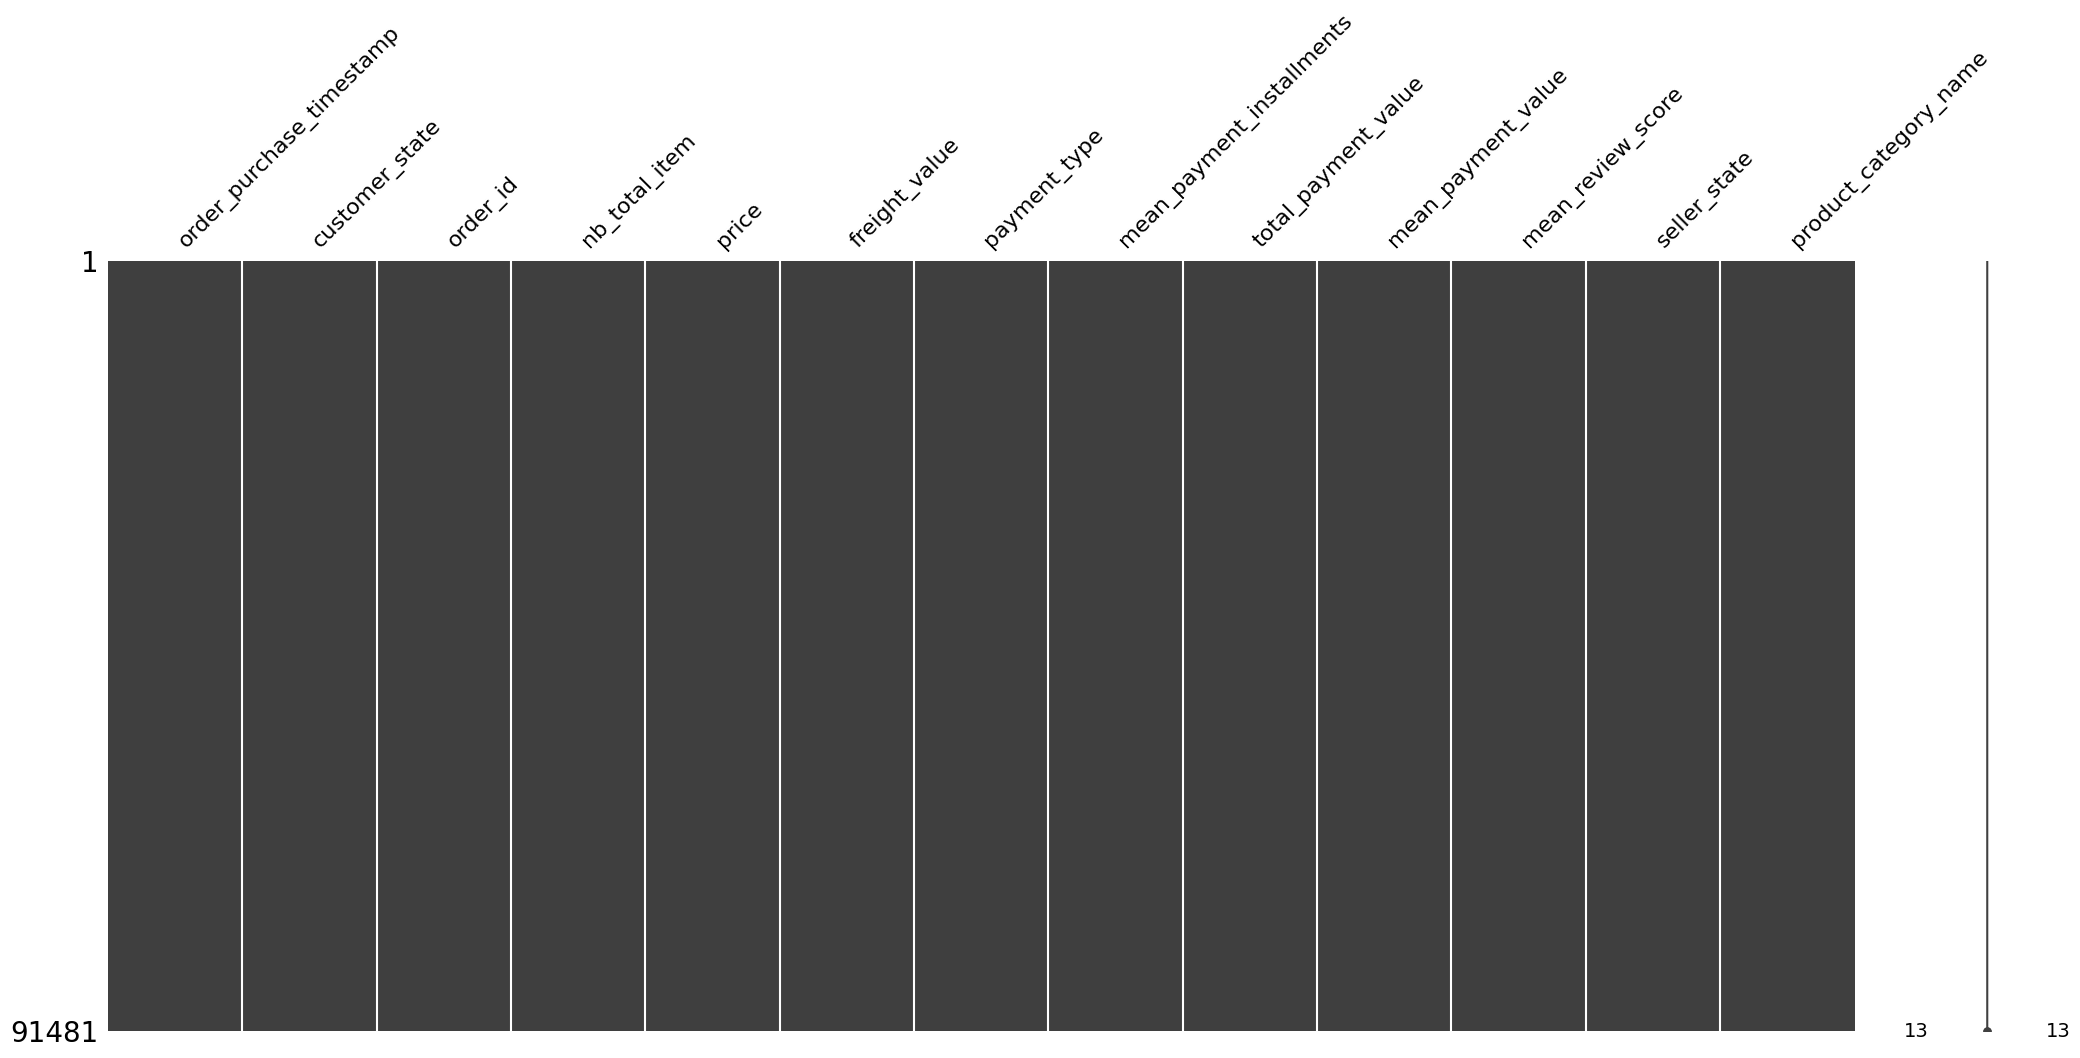

In [147]:
#Valeurs manquantes 
print(df.isna().sum().sort_values())
print(msno.matrix(df))

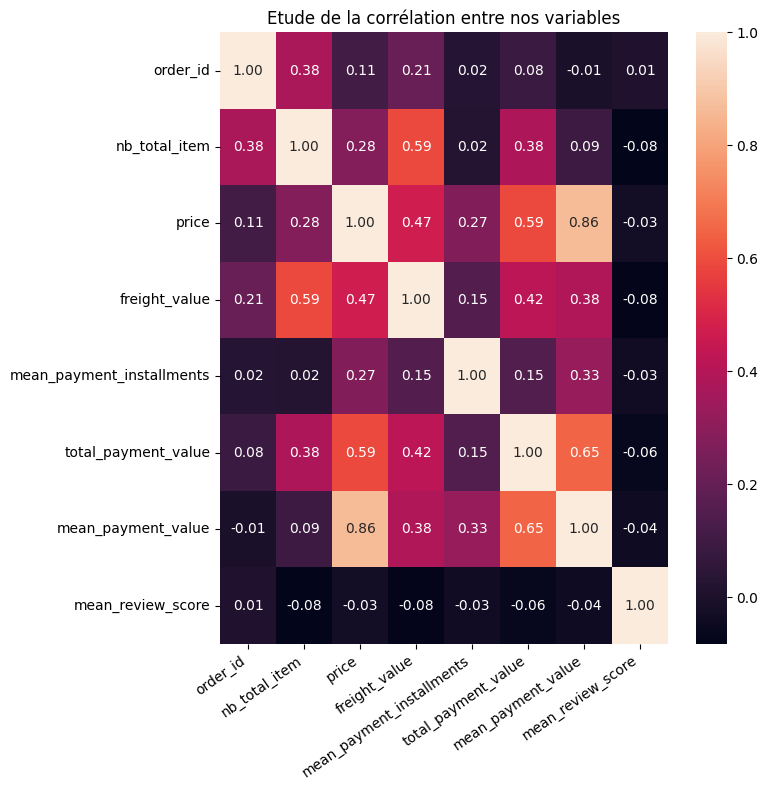

In [148]:
colonnes_quanti = df.select_dtypes(include=['float64',  'int64']).columns

#Matrice de corrélation 
plt.figure(figsize=(8,8))
sns.heatmap(df[colonnes_quanti].corr(), annot=True, fmt='.2f')
plt.title('Etude de la corrélation entre nos variables')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.show()

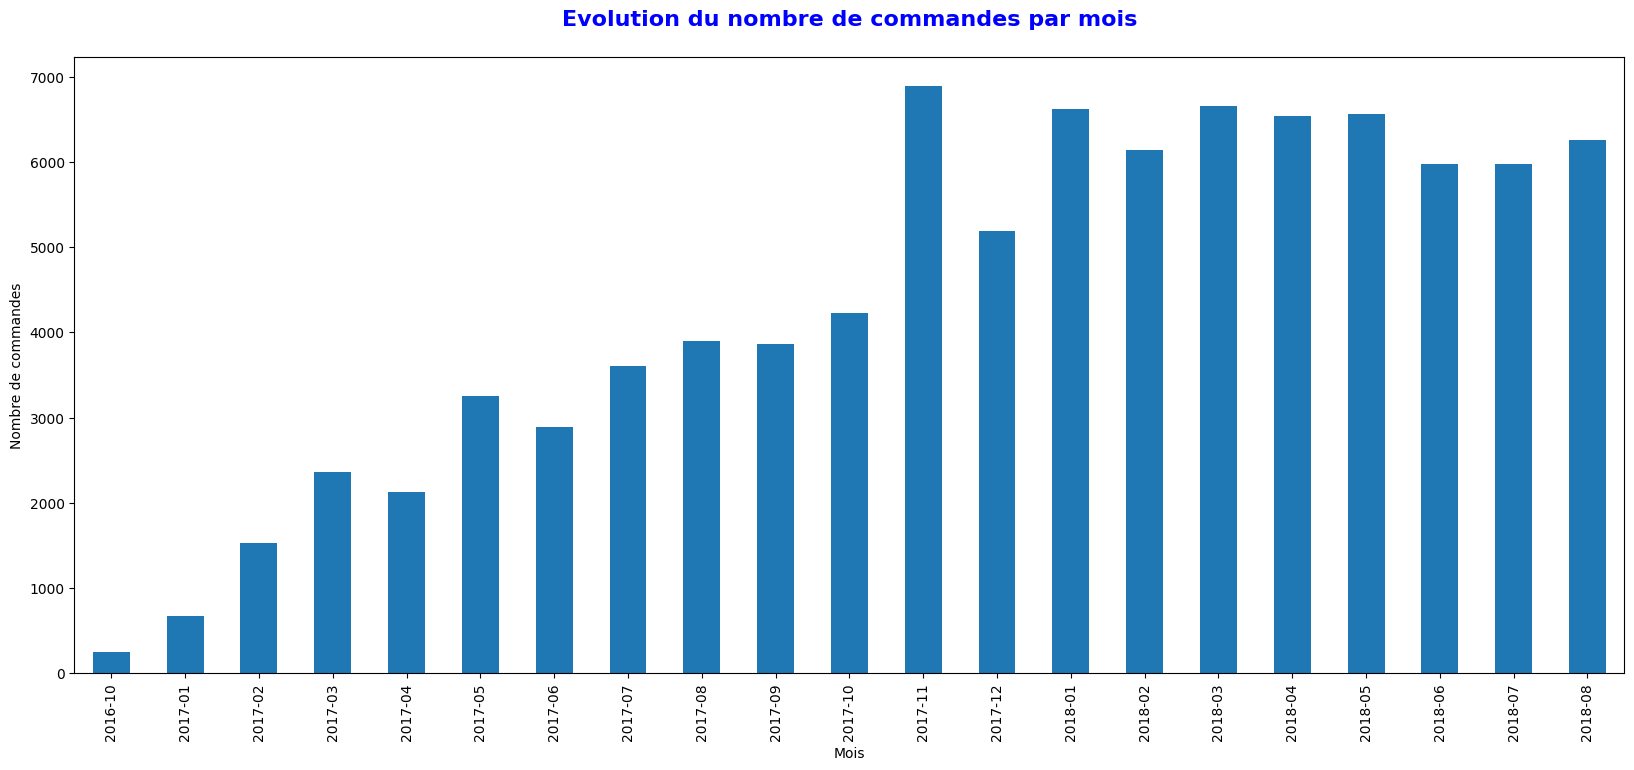

In [149]:
orders_per_month = df.groupby(df['order_purchase_timestamp'].dt.to_period('M')).count()['order_id']

font_title = {'fontsize': 16, 'fontweight': 'bold', 'color': 'blue'}
fig = plt.figure(figsize=(20, 8))
ax = orders_per_month.plot(kind='bar')
ax.set_ylabel("Nombre de commandes")
ax.set_xlabel("Mois")
plt.title(f"Evolution du nombre de commandes par mois\n",
          fontdict=font_title)
plt.show()

customer_state
SP    41.989047
RJ    12.699905
MG    11.782775
RS     5.547600
PR     5.116910
SC     3.680546
BA     3.381030
DF     2.163291
ES     2.064910
GO     2.008067
PE     1.657175
CE     1.353286
PA     0.976159
MT     0.916037
MA     0.752069
MS     0.732393
PB     0.536723
RN     0.497371
PI     0.495185
AL     0.415387
SE     0.354172
TO     0.287491
RO     0.247046
AM     0.151944
AC     0.080891
AP     0.071053
RR     0.041539
Name: count, dtype: float64


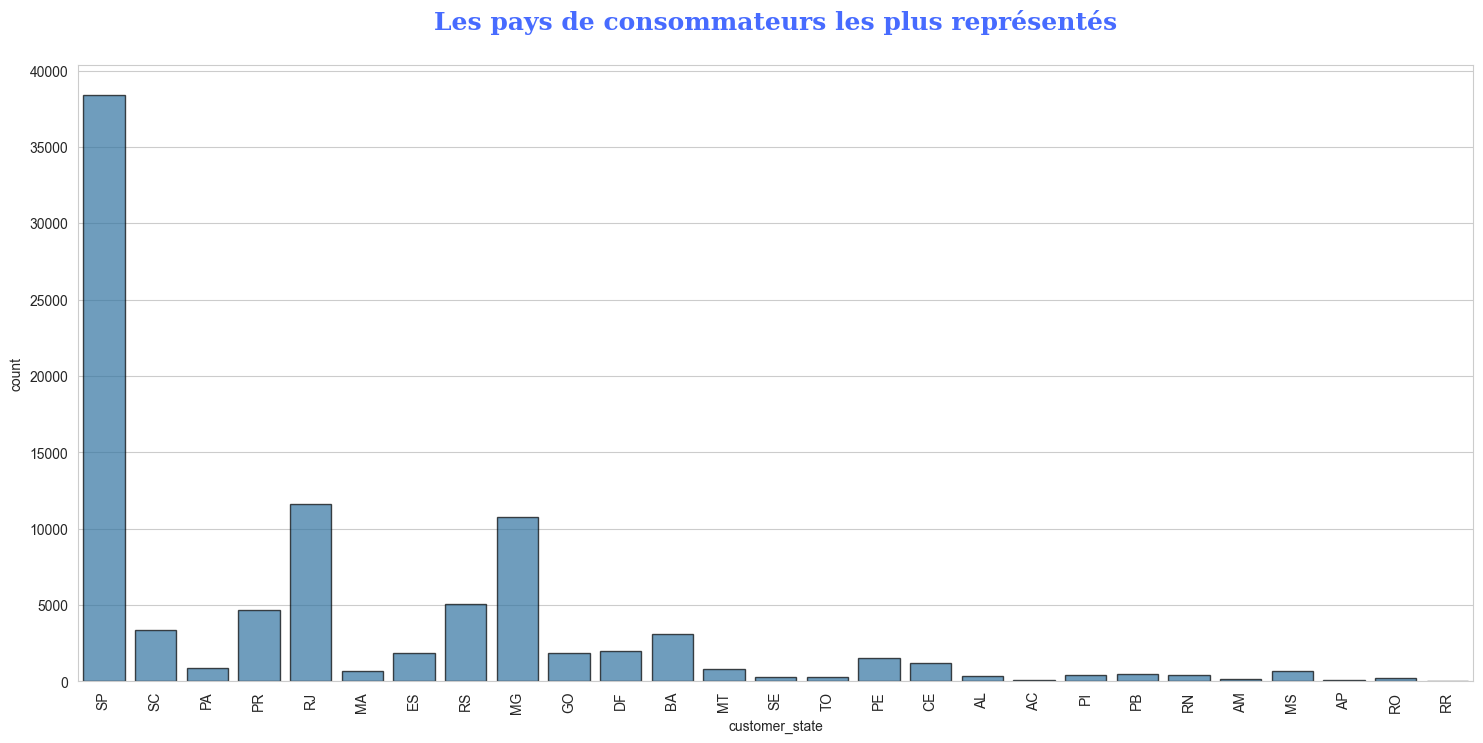

In [150]:
value_counts = df["customer_state"].value_counts()
total = value_counts.sum()
percentages = (value_counts / total) * 100
print(percentages)

# Plot des proportions de pays d'acheteur
sns.set_style("whitegrid")
font_title = {"family": "serif",
              "color":  "#476bff",
              "weight": "bold",
              "size": 18}

fig = plt.figure(figsize=(18, 8))
sns.countplot(data=df, x="customer_state",
              edgecolor="black", alpha=0.7)
plt.xticks(range(0, len(df["customer_state"].unique())),
           df["customer_state"].unique(),
           rotation=90)
plt.title(f"Les pays de consommateurs les plus représentés\n",
          fontdict=font_title)
plt.show()

seller_state
SP    70.446322
MG     8.016965
PR     7.831134
RJ     4.385610
SC     3.778927
RS     2.023371
DF     0.860288
BA     0.585914
GO     0.477695
PE     0.433970
MA     0.412107
ES     0.324658
MT     0.147572
CE     0.089636
RN     0.054656
MS     0.051377
PB     0.033887
RO     0.014211
PI     0.010931
SE     0.009838
PA     0.007652
AM     0.003279
Name: count, dtype: float64


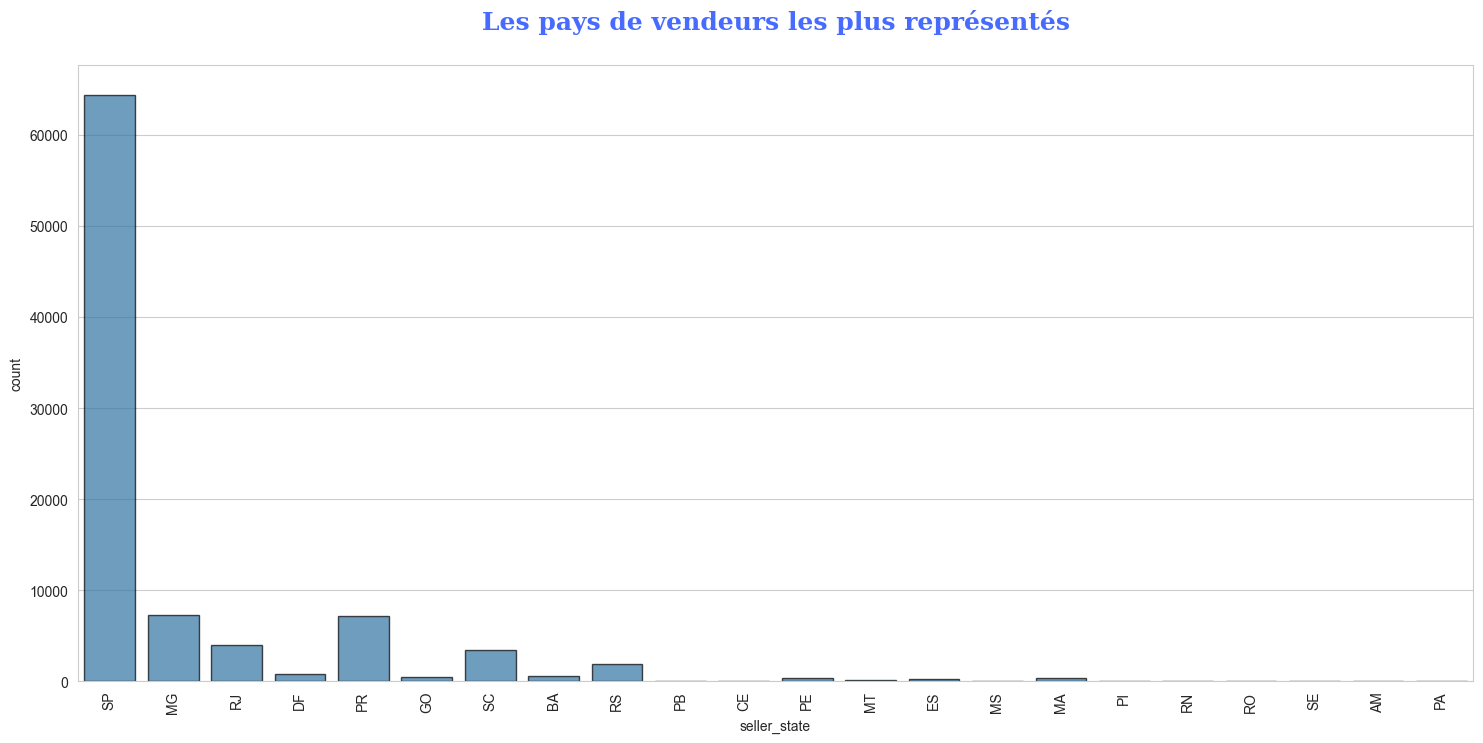

In [151]:
value_counts = df["seller_state"].value_counts()
total = value_counts.sum()
percentages = (value_counts / total) * 100
print(percentages)

# Plot des proportions de pays des vendeurs
sns.set_style("whitegrid")
font_title = {"family": "serif",
              "color":  "#476bff",
              "weight": "bold",
              "size": 18}

fig = plt.figure(figsize=(18, 8))
sns.countplot(data=df, x="seller_state",
              edgecolor="black", alpha=0.7)
plt.xticks(range(0, len(df["seller_state"].unique())),
           df["seller_state"].unique(),
           rotation=90)
plt.title(f"Les pays de vendeurs les plus représentés\n",
          fontdict=font_title)
plt.show()

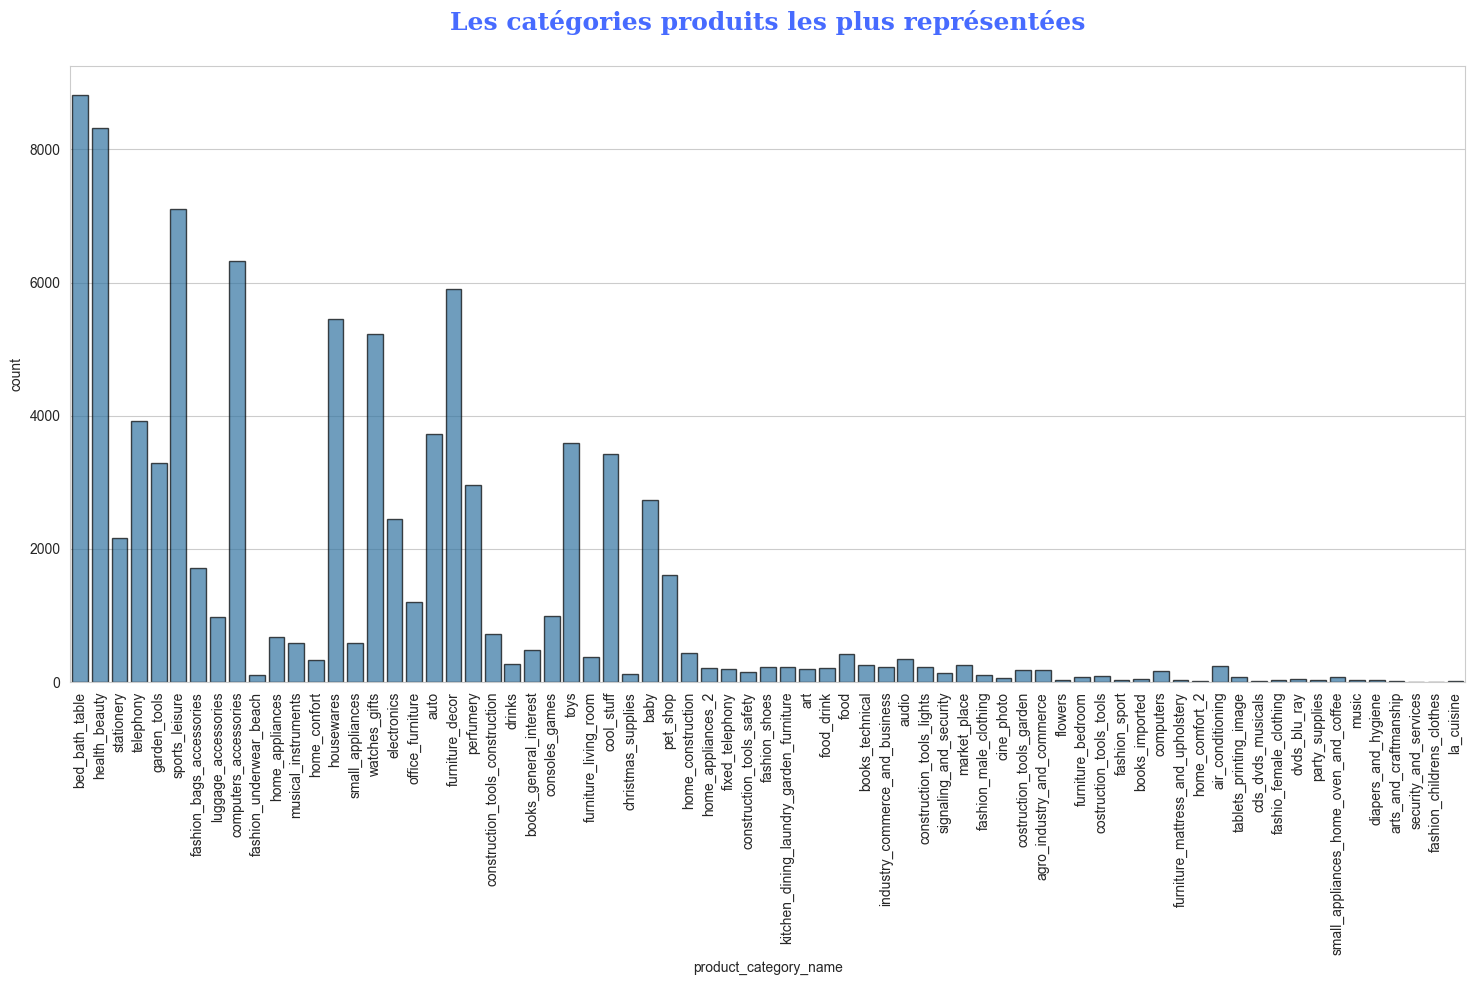

In [152]:
# Plot des proportions de catégories de produit
sns.set_style("whitegrid")
font_title = {"family": "serif",
              "color":  "#476bff",
              "weight": "bold",
              "size": 18}

fig = plt.figure(figsize=(18, 8))
sns.countplot(data=df, x="product_category_name",
              edgecolor="black", alpha=0.7)
plt.xticks(range(0, len(df["product_category_name"].unique())),
           df["product_category_name"].unique(),
           rotation=90)
plt.title(f"Les catégories produits les plus représentées\n",
          fontdict=font_title)
plt.show()

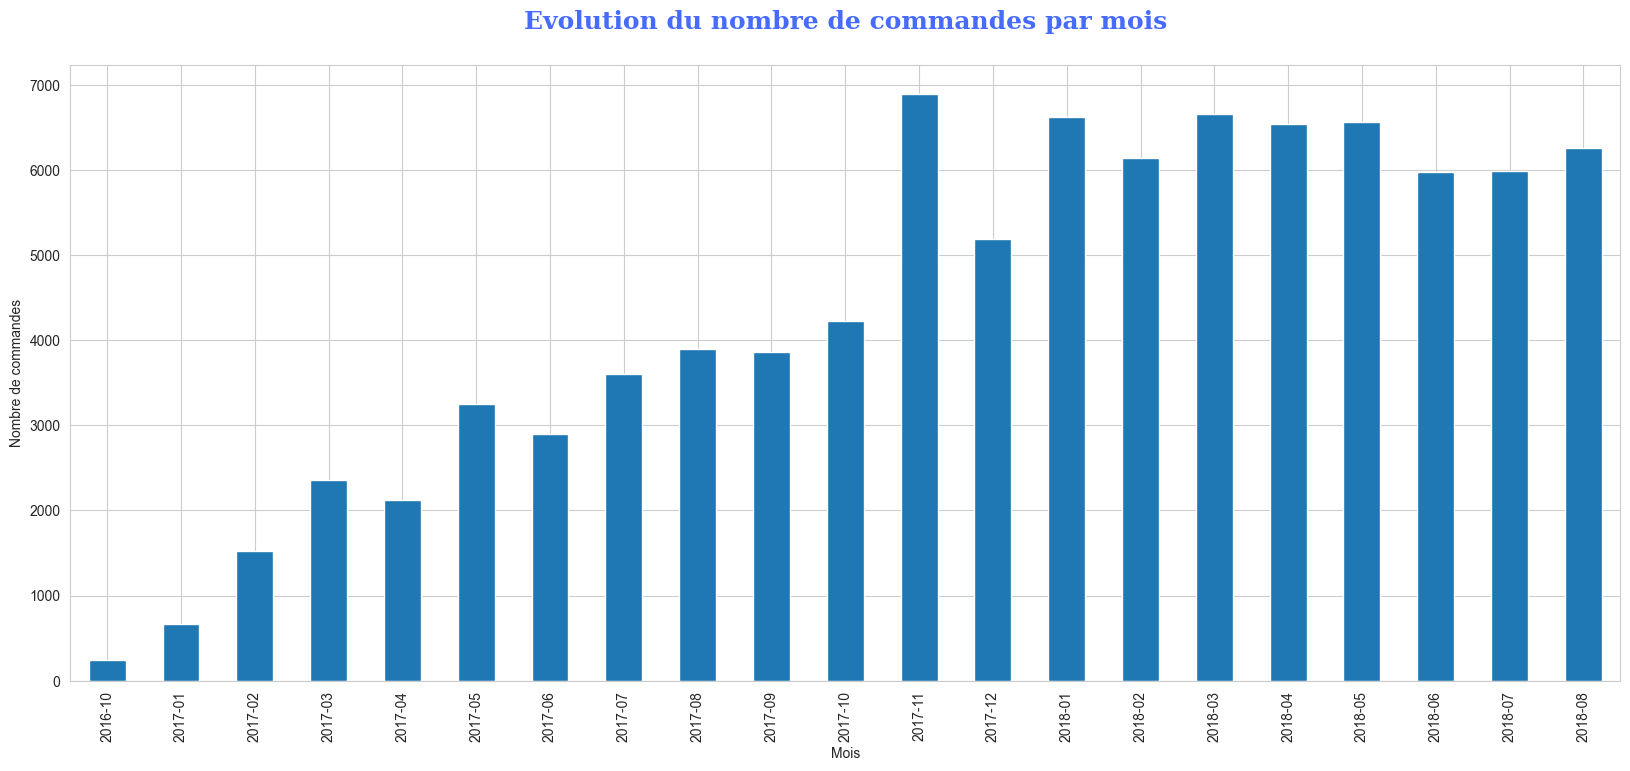

In [153]:
orders_per_month = df.groupby(df['order_purchase_timestamp'].dt.to_period('M')).count()['order_id']

fig = plt.figure(figsize=(20, 8))
ax = orders_per_month.plot(kind='bar')
ax.set_ylabel("Nombre de commandes")
ax.set_xlabel("Mois")
plt.title(f"Evolution du nombre de commandes par mois\n",
          fontdict=font_title)
plt.show()

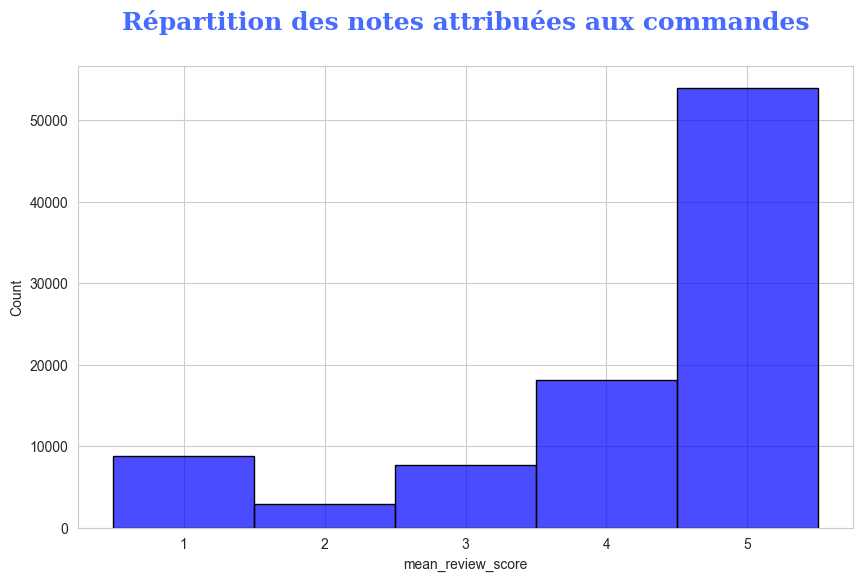

In [154]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="mean_review_score", 
             discrete=True,
             edgecolor="black",
             color="#0000FF", alpha=0.7)
plt.title(f"Répartition des notes attribuées aux commandes\n",
          fontdict=font_title)
plt.show()